# Etude de la densité phonique et de la chaleur spécifique du cristal de $Sr_2NCl$

#### Raphaël Roekens 70732200


## 1. Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.graph_objects import Scatter
from scipy.integrate import quad
from scipy.optimize import minimize

In [56]:
mp_key ="iX81lxwugQ7QfGznstwLyMrndo3WUZbE"
mp_id = "mp-23033"

with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### définition des constantes

In [72]:
h =6.626070*1e-34   #[J.s]
kb = 1.380649*1e-23 #[J/K]
R = 8.314         #[J/(K.mol)]
Nat = len(prim_struc)

Temperatures = np.arange(1,600,5 )
length = len(Temperatures)

# expérimental heat capacity data
cv = np.zeros(len(Temperatures))
for i in range(len(Temperatures)):
    cv[i] = ph_dos.cv(Temperatures[i])/(3*Nat*R)


c:\Users\roeke\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymatgen\phonon\dos.py:200: RuntimeWarning:

overflow encountered in square



## 1. Comparaison des modèles d'Einstein et de Debye pour la chaleur spécifique

### 1. Calcul de $\theta_D$ et $\theta_E$

La température spécifique $\theta_i$ représente la température à partir de laquelle tous les modes de vibrations du résaux cristallins sont activés. 

La chaleur spécifique d'Einstein est obtenue en faisant l'hypothèse que tous les atomes du cristal vibrent à une fréquence naturelle $\omega_E$. On a alors : 

\begin{equation}
\frac{C_v}{3 Nat R} = (\frac{\Theta_E}{T})^2  \frac{exp(\frac{\Theta_E}{T})}{(exp(\frac{\Theta_E}{T})-1)^2}
\tag{1}
\end{equation}
avec $\Theta_E = \frac{\hbar\omega_E}{k_B}$

La chaleur spécifique de Debye est obtenue en faisant l'hypothèse d'une courbe de dipersion linéaire jusqu'à une fréquence maximale. Cela donne :

\begin{equation}

\frac{C_v}{3 Nat R} = 3 (\frac{T}{\Theta_D})^3 \int_{0}^{\frac{\Theta_D}{T}} \frac{x^4 e^x}{(e^x-1)^2}dx

\tag{2}
\end{equation}

avec $\Theta_D = \frac{\hbar\omega_D}{k_B}$

In [100]:

def ComputeCvEinstein(ThetaE, T):
    """
    Compute the heat capacity using the Einstein model.
    """
    E= ThetaE / T
    exp = np.exp(E)
    cvE = (E**2) * (exp / (exp - 1)**2)
    return cvE

def ComputeCvDebye(ThetaD, T):
    """
    Compute the heat capacity using the Debye model.
    """
    D = ThetaD / T
    def IntegrandDebye(x):
        return x**4 * np.exp(x) / (np.exp(x) - 1)**2
    res, _ = quad(IntegrandDebye, 0.0000001, D)
    cvD = 3 * (1/D)**3 * res
    return cvD

def EinsteinError(ThetaE):
    """
    Compute the error between the experimental and theoretical heat capacity using the Einstein model.
    """
    predicted_cv = np.zeros(length)
    for i in range(length):
        predicted_cv[i] = ComputeCvEinstein(ThetaE, Temperatures[i])
    return np.sum((cv - predicted_cv)**2)

def DebyeError(ThetaD):
    """
    Compute the error between the experimental and theoretical heat capacity using the Debye model.
    """
    predicted_cv = np.zeros(length)
    for i in range(length):
        predicted_cv[i] = ComputeCvDebye(ThetaD, Temperatures[i])
    return np.sum((cv - predicted_cv)**2)


In [ ]:
result_Einstein = minimize(EinsteinError, x0=100)  
ThetaE_opt = result_Einstein.x[0]
Einstein_error_min = result_Einstein.fun

result_Debye = minimize(DebyeError, x0=100)  
ThetaD_opt = result_Debye.x[0]
Debye_error_min = result_Debye.fun

print(f"Valeur optimale de ThetaE : {ThetaE_opt} [K]")
print(f"Erreur minimale au sens des moindres carrés : {Einstein_error_min}")

print(f"Valeur optimale de ThetaD : {ThetaD_opt} [K]")
print(f"Erreur minimale au sens des moindres carrés : {Debye_error_min}")

Valeur optimale de ThetaE : 239.33683802165228 [K]
Erreur minimale au sens des moindres carrés : 0.10376850783002564
Valeur optimale de ThetaD : 324.74772277696087 [K]
Erreur minimale au sens des moindres carrés : 0.04547507906895677


C:\Users\roeke\AppData\Local\Temp\ipykernel_21592\288638757.py:27: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\roeke\AppData\Local\Temp\ipykernel_21592\288638757.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



### Commentaire :

L'approximation d'Einstein est plus grossière que celle de Debye et aboutit bien à une erreur par rapport à la courbe expérimentale plus élevée.

### 2. Visualisation de la chaleur spécifique

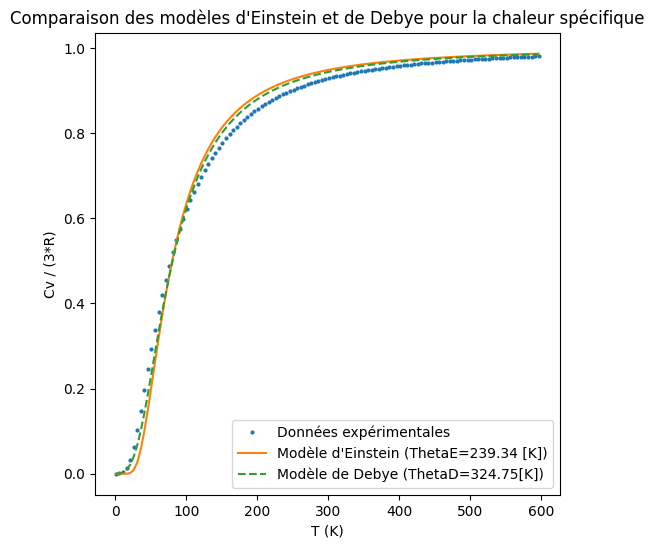

In [102]:

# Comparaison des courbes
plt.figure(figsize=(6, 6))
plt.plot(Temperatures, cv, 'o', label="Données expérimentales ",markersize=2)
plt.plot(Temperatures, [ComputeCvEinstein(ThetaE_opt, T) for T in Temperatures], '-', label=f"Modèle d'Einstein (ThetaE={ThetaE_opt:.2f} [K])")
plt.plot(Temperatures, [ComputeCvDebye(ThetaD_opt, T) for T in Temperatures], '--', label=f"Modèle de Debye (ThetaD={ThetaD_opt:.2f}[K])")

plt.xlabel("T (K)")
plt.ylabel("Cv / (3*R)")
plt.legend()
plt.title("Comparaison des modèles d'Einstein et de Debye pour la chaleur spécifique")
plt.show()

## 1. Comparaison des modèles d'Einstein et de Debye pour la densité phonique

La densité de modes normaux $g(\omega)$ est tel que $g(\omega)d\omega$ décrit le nombre détats phoniques possible dans un interval $d\omega$ de fréquence.

Dans le modèle d'Einstein, il n'y a qu'une seul fréquence possible. On a donc :
\begin{equation}
g_E(\omega) = 3 N_{at} \delta(\omega-\omega_E)
\tag{3}
\end{equation}

Dans le modèle de Debye, l'approximation linéaire, $\omega_{\sigma}(\bold{q}) = vq$ , entraine une densité parabolique de la fréquence

\begin{equation}
g_D(\omega) = \frac{3N_{at}\Omega}{2 \pi^2}\frac{\omega^2}{v^3}~~ si ~~ \omega<\omega_D
~~~~g_D(\omega) = 0 ~~ si non
\tag{4}
\end{equation}

In [126]:

# einstein model
fE = kb * ThetaE_opt / h * 1e-12  # [THz]

#Debye model
freq = ph_dos.frequencies
fD = kb * ThetaD_opt / h * 1e-12  # [THz]
vol = prim_struc.volume
q_D = (6*np.pi**2/vol)**(1/3)


DOS_D = np.zeros(len(freq))
for i in range(len(freq)):
    if freq[i] < fD:
        DOS_D[i] = (3*Nat*vol*(freq[i])**2*q_D**3)/(2*(np.pi**2)*fD**3)
    else:
        DOS_D[i] = 0


fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.add_trace(Scatter(
        x=freq, y=DOS_D, mode='lines',
        line=dict(color='green'), name=" DOS selon Debye",)
        )
fig_ph_dos.add_annotation(
    x=fE,  y=6, ax=fE,  ay=0,  xref="x",  yref="y",  axref="x",  ayref="y",  
    showarrow=True,arrowhead=2,  arrowsize=1.5,arrowwidth=1,arrowcolor="orange", 
    text="fE",  font=dict(color="orange"),align="center",
)

fig_ph_dos.update_layout(yaxis=dict(range=[0, 7]))
fig_ph_dos.show()